**Ofir David**: [https://prove-me-wrong.com/](https://prove-me-wrong.com/)

**Contact**:	 [totallyRealField@gmail.com](mailto:totallyRealField@gmail.com)
<div style="width: 45%; margin: 0 auto; height: 10px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>
<h1 style="text-align:center;">Learning Models</h1>
<div style="width: 45%; margin: 0 auto; height: 15px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>

The goal of these notes is to get some intuition behind the Attention that everyone talk about. This was done mainly by following the great [YouTube lecture series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) by Andrej Karpathy, and adding to myself extra notes whenever I needed.

In [1]:
# import importlib
# import os
# import sys
# import subprocess
# from typing import List, Optional
# import inspect

# def import_project_modules(modules: List[str], repo_url: Optional[str] = None, branch: Optional[str] = None) -> dict:
#     """
#     Imports modules either from local source (and reloads them), or installs from a GitHub repo and imports.

#     Args:
#         modules (List[str]): List of dotted module paths to import (e.g., ["general.model_tester"])
#         repo_url (Optional[str]): GitHub URL of the repo (e.g., "https://github.com/user/repo"). If None, import locally.
#         branch (Optional[str]): Branch name to install from (only applies when repo_url is given).

#     Returns:
#         dict: Mapping from module name to module object.
#     """
#     imported_modules = {}
#     caller_globals = inspect.currentframe().f_back.f_globals

#     if repo_url is None:
#         # Local import
#         project_root = os.path.abspath("..")
#         if project_root not in sys.path:
#             sys.path.insert(0, project_root)

#         for mod_name in modules:
#             if mod_name in sys.modules:
#                 mod = importlib.reload(sys.modules[mod_name])
#                 print(f'reloaded {mod_name}')
#             else:
#                 mod = importlib.import_module(mod_name)
#                 print(f'loaded {mod_name}')

#             var_name = mod_name.split(".")[-1]
#             caller_globals[var_name] = mod
#             imported_modules[mod_name] = mod

#     else:
#         # GitHub install via pip
#         pip_url = f"git+{repo_url}"
#         if branch:
#             pip_url += f"@{branch}"

#         print(f"Installing from: {pip_url}")
#         subprocess.check_call([sys.executable, "-m", "pip", "install", pip_url])

#         for mod_name in modules:
#             mod = importlib.import_module(mod_name)
#             print(f'loaded {mod_name}')
#             var_name = mod_name.split(".")[-1]
#             caller_globals[var_name] = mod
#             imported_modules[mod_name] = mod

#     return imported_modules


# import_project_modules(['general.model_tester'], repo_url='https://github.com/TotallyReal/ai_projects.git', branch='attention')
# print(model_tester.__name__)

# 🐍 Python initialization

In [2]:
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import List

np.set_printoptions(precision=2)

project_root = os.path.abspath("..")  
if project_root not in sys.path:
    sys.path.append(project_root)

from general import model_tester
from attention import probabilistic, text_data, visual, generative
# in case I updated the code  
importlib.reload(model_tester)  
importlib.reload(probabilistic)   
importlib.reload(text_data)    
importlib.reload(visual)    
importlib.reload(generative)    

def print_in_columns(words: List[str], num_columns=3, space=30):
    import math
    # Calculate how many words should go in each column
    words_per_column = math.ceil(len(words) / num_columns)
    columns = [words[i:i + words_per_column] for i in range(0, len(words), words_per_column)]
    columns[-1] += ['']*(words_per_column-len(columns[-1]))

    # Ensure the number of columns matches the requested number
    # If there are leftovers, append them to the last column
    if len(columns) < num_columns:
        columns.extend([[]] * (num_columns - len(columns)))

    # Print the columns side by side
    for row in zip(*columns):
        print("   ".join(word.ljust(space) for word in row))

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


---
# 🗃️ Preparing the Data

We begin by getting a text source that we want to learn from, and in this case some Alice in wonderland:

In [3]:
with open(f'data/alice.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(f'{text[:1000]} ...')

Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,’ thought Alice `without pictures or conversation?’

So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.

There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear! Oh dear! I shall be late!’ (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually TOOK A WATCH OUT OF ITS WAISTCOAT- POCKET, 

While we are used to reading letters, it is much easier to use numbers in the computations. For that we need to find out all the letters used in the text, and assign for each one of them a number. This is done in the `text_data.TextData` class.

### Remark
> When I process the text below, I change all the uppercase letters into their lowercase analouge. We of course lose some of the information like this, e.g. rules like captial letter in beginning of a sentence, or first letter in a name, or ways to indicate the tone or amphasis of a word. However, this is not too important for this study, and it both reduces the size of alphabet, and combines word together which might "seem" different because of uppercase letters.

In [4]:
processed_text = text_data.TextData(file_name='alice')
print(f'Letters used in the text:\n{processed_text.alphabet}\n')

print('Correspondence between char and index')
print_in_columns([f'{repr(c)}: {i}' for c,i in processed_text.letter_to_index.items()], num_columns = 6, space = 10)

Letters used in the text:
['\n', ' ', '!', '(', ')', '*', ',', '-', '.', ':', ';', '?', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '–', '‘', '’', '“', '”']

Correspondence between char and index
'\n': 0      '.': 8       'c': 16      'k': 24      's': 32      '–': 40   
' ': 1       ':': 9       'd': 17      'l': 25      't': 33      '‘': 41   
'!': 2       ';': 10      'e': 18      'm': 26      'u': 34      '’': 42   
'(': 3       '?': 11      'f': 19      'n': 27      'v': 35      '“': 43   
')': 4       '_': 12      'g': 20      'o': 28      'w': 36      '”': 44   
'*': 5       '`': 13      'h': 21      'p': 29      'x': 37                
',': 6       'a': 14      'i': 22      'q': 30      'y': 38                
'-': 7       'b': 15      'j': 23      'r': 31      'z': 39                


We can now convert between the data as string and data as list of integers:

In [5]:
sentence = processed_text.text[:125]
sentence = sentence.lower()
integer_message = processed_text.to_int(sentence)
string_message = processed_text.to_text(integer_message)
print(f'As integers:\n{integer_message}')
print(f'\nTransformed back:\n{string_message}')

As integers:
[17 28 36 27  1 33 21 18  1 31 14 15 15 22 33  7 21 28 25 18  0  0 14 25
 22 16 18  1 36 14 32  1 15 18 20 22 27 27 22 27 20  1 33 28  1 20 18 33
  1 35 18 31 38  1 33 22 31 18 17  1 28 19  1 32 22 33 33 22 27 20  1 15
 38  1 21 18 31  1 32 22 32 33 18 31  1 28 27  1 33 21 18  1 15 14 27 24
  6  1 14 27 17  1 28 19  1 21 14 35 22 27 20  1 27 28 33 21 22 27 20  1
 33 28  1 17 28]

Transformed back:
down the rabbit-hole

alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do


Finally, our goal is to given the first $n$ letter, predict the next letter. In general, this can be quite hard as $n$ grows to infinity, so we restrict ourself to know the last few letters for some small fixed `window_size` (e.g. given the last 5 letter, find the next 1). We can retrieve this data from the text by:

In [6]:
X, Y = processed_text.get_data(window_size = 5)
for i in range(10):
    print(f'{X[i]} -> {Y[i]}')
print('...')

[17 28 36 27  1] -> 33
[28 36 27  1 33] -> 21
[36 27  1 33 21] -> 18
[27  1 33 21 18] -> 1
[ 1 33 21 18  1] -> 31
[33 21 18  1 31] -> 14
[21 18  1 31 14] -> 15
[18  1 31 14 15] -> 15
[ 1 31 14 15 15] -> 22
[31 14 15 15 22] -> 33
...


### Problem:
> Build a model that can "learn" the function described above.

---
# 🎲 The probabilistic model

The simplest, and probably the most accurate, model is the probabilistic model. We are going to use this for prediction, however, if we know how to predict well enough, then we can also use this knowledge to compress messages. I wrote another [google colab notebook about compression](https://colab.research.google.com/drive/14iJaLgw66eKPS27O2w4_szyeTwQTGn7U), which have very similar ideas to what happens here.

## 📊 Computing frequencies

Ignoring for now the actual prediction from previous letters, or equivalently if `window_size=0`, the best way to predict the next letter is by its frequency in the original text. Namely, if the letter `e` constitues $0.1$ of the letter, then in the generated output of our model, we would like to see `e` at around $0.1$ of the message. 

For this we simply count the frequencies of each letter in the text, and then normalize it to have a probability vector.

' ' : 0.181991   'h' : 0.050537   'u' : 0.023187   'm' : 0.015251   'k' : 0.007814   '–' : 0.001582   '*' : 0.000730   '”' : 0.000304
'e' : 0.091787   'n' : 0.049088   'w' : 0.019475   'f' : 0.013900   '`' : 0.006987   ':' : 0.001558   'j' : 0.000706   '‘' : 0.000268
't' : 0.074162   's' : 0.045997   'g' : 0.018051   '’' : 0.011295   '.' : 0.006086   '?' : 0.001461   'z' : 0.000633   '_' : 0.000024
'a' : 0.063329   'r' : 0.037562   ',' : 0.016444   '\n' : 0.010930   'v' : 0.005465   'q' : 0.001083   ')' : 0.000450             
'o' : 0.058108   'd' : 0.034458   'c' : 0.016395   'p' : 0.010638   '!' : 0.003566   '-' : 0.001035   '(' : 0.000450             
'i' : 0.054079   'l' : 0.034178   'y' : 0.015799   'b' : 0.010419   ';' : 0.001619   'x' : 0.000767   '“' : 0.000353             


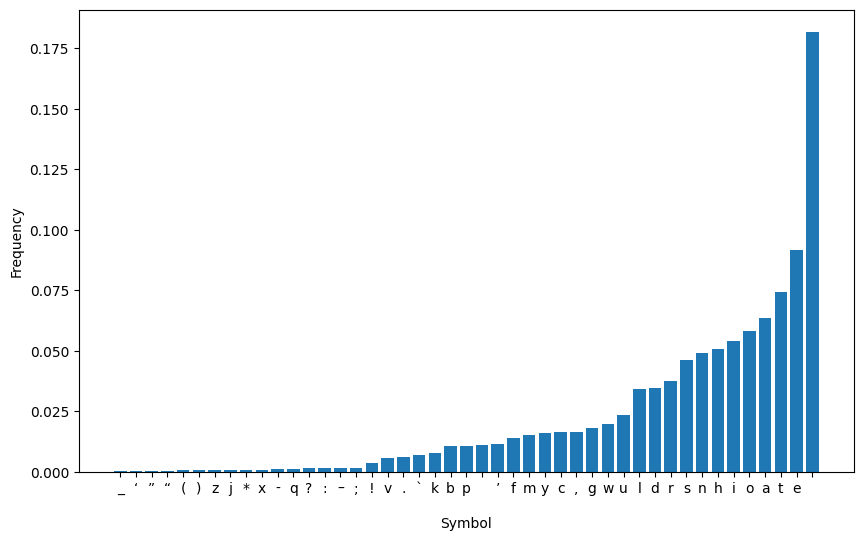

In [7]:
prob_model0 = probabilistic.ProbModel(abc_size=processed_text.abc_size, window_size=0)
X, Y = processed_text.get_data(window_size = 0)
prob_model0.train(X, Y)

def print_probaility_bars(probabilities: List[float], alphabet: List[str], order_sorted: bool):

    freq_list = list(zip(probabilities, alphabet))
    if order_sorted:
        freq_list = sorted(freq_list)
    
    freq_str = [f'{repr(symbol)} : {freq:7f}' for freq, symbol in reversed(freq_list)]
    print_in_columns(freq_str, num_columns = 8, space = 10)
    
    plt.figure(figsize=(10,6))
    plt.bar([s for _,s in freq_list], [f for f,_ in freq_list])
    plt.xlabel('Symbol')
    plt.ylabel('Frequency')
    plt.show()

print_probaility_bars(prob_model0.probabilities, processed_text.alphabet, True)

As can be "seen", the letter which appears the most, around $~0.18$ is the space character, or alternatively we expect the words to have around 4 or 5 letters. So if when generating the new text we try to keep the words with this length, it would appear more "natural". After it we have `e` which appear $0.09$ of the time, `t` which appears $0.07$, and at the end letters like `q, x, j, z` almost never appear. Trying to keep these percentages in the generate output will make it more natural looking.

Another example is that the new line `\n` appears $~0.01$ of the time, so each paragraph should be around $100$ character. Using just this **no memory** model, we can create "natural" looking text. At each index, we choose a letter according to it probability from above.

In [8]:
generated_int_message = prob_model0.generate(initial_message='', num_letters=1000)
generated_text_message0 = processed_text.to_text(generated_int_message)
print(generated_text_message0)

sud hgad eeitho too
`sanyswk,
texlk omeetmrhidhe th .y  r ’ikh ntn r
i itnh ol,ooitsdssramrnuesin t ln osnnts hl kwi ef`l neake rsbht aetm!uaheso s i
lsaeu ,iyeas uh  hes  n,ay lu
dr n hittd`dlidhmlldl`hissfhda cieio, nfaa hvtlieembwmyrrtbfmh
e dtis hta,ehede wn
amonaew hd srl r,aglh,ohtdetk te  lkelaoalhardetfnhg– ddo:t ossaia oay? aoer`na uysr c,ire netsc.ifi e hft
o ldntthwstgiir ety ad epwhohonkhhaaugnretoote gee oeeseota eahawaeirfslalob ntntrn kiu, ’io r eneowm hiim’io e  lefl ;ttarfe–wulsbslah awa e,uhhnraehee  t sgenorl do
s i  .
hinaovfe!hss’oroir
egni o- a ht nuia thcu`lwrunght   l:  liessgwada dootctoadi te oit et hd cietoeto hsy al
fswpsydpaiaam lsptd  btnrmotl ,enaaan io   e’ de’odh ,p: eeeeyo  eiaonerwtd l `n’un
s he!a raatcprsh  en hio od, etuype’watse n d l  dolws af
 cw ’samarmyo   tnmeag o nenwg `c l ’r tati eertes y` ) unreed wenlnsdlartlogaashrtttpstvlnldn gusdtn wn a
 ioigu ir)eoduu iieharg sugey–ie e rti
ieh hrolo o`olhhe
ieheit ’fh’tewdbsne rlpa ce,yao ms g  g tr

This text of course has no meaning, but "from a far" it seems fine. It has the right length of words more or less, we see familiar letters around the same amount that we expect, etc. Next we want to improve this idea by actually predicting according to the previously seen letters.

## ➡️ From past to future letter

Now we want to predict the next letter by looking at the last `window_size` of letters. Here too we can create probability vectors, but instead of just one such vector, we create a vector for each tuple of `window_size` letters. Namely, for each such tuple we look at all the possible letters coming after it, and from their frequencies create a probability vector.

For example, consider the following text over the alphabet `A,B`:
> `AABABAAABABAAB`

For the `window_size=2`, we can choose the tuple `AA` and ask what is the probability to see `A` and `B` after it. For that, lets write all the 2-tuples, and the following letter:

|AA|AB|BA|AB|BA|AA|AA|AB|BA|AB|BA|AA|
|--|--|--|--|--|--|--|--|--|--|--|--|
|B |A |B |A |A |A |B |A |B |A |A |B |

So for example, if we see `AA` then there is one case where the next letter is `A` three cases where it is `B`. In other words, `B` is three times more likely to appear, so our weights vector should be $(1,3)$, and it probabilistic normalization is $(0.25, 0.75)$. For the rest of the tuples we have:

> `AA => (1, 3) => (0.25, 0.75)`
> 
> `AB => (4, 0) => (1   , 0   )`
> 
> `BA => (2, 2) => (0.5 , 0.5 )`
> 
> `BB => (0, 0) => ?`

### Remark:
> We see that there is an issue with the normalization in the `BB` case, because it never appears as a tuple. We can either ignore it completely, since we never should generate `BB` where we need to predit the next letter, or alternatively add a small $\varepsilon>0$ to each frequency to avoid having just zeros. We will use this second method.

If `window_size=1`, then we simply ask given a letter `c`, what is the probability to see any of the letters after it. In this simple case, we can actually view this information inside one simple plot.

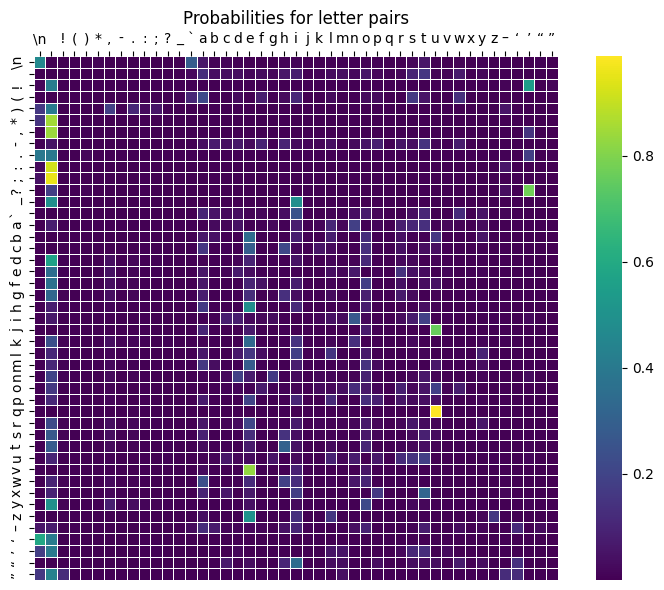

In [9]:
prob_model1 = probabilistic.ProbModel(abc_size=processed_text.abc_size, window_size=1)
X, Y = processed_text.get_data(window_size = 1)
prob_model1.train(X, Y, epsilon=0.001)

visual.view_pair_probabilities(None, [repr(c)[1:-1] for c in processed_text.alphabet], prob_model1.probabilities)

Let's see what we can learn from this:

- The second "invisible" character is the space character, and we can see that there are several characters afterwhich we have high probability to see a space. For example, after `; : , *`, which is not too surprizing. We already saw that there are many space characters in the text, and there are several letters which are more likely to be at the end of a word, like `d` and `y`.
- There are couple more very bright squares, meaning that there are letter which have almost unique way to continue:
      - After `?` there is usually `'`. This means that a question mark is usually inside a quote that a person say, and in the end of that quote.
      - The letters `j` and `q` are usually followed by `u` (like in the words `just` and `question`)
      - The letter `v` is usually followed by `e` (like in `very`).

Now that we have these new rules, we can generate text that look more natural. To do this we choose our initial letter, say `a`, and then look for the probabilities to see letters after `a`:

'n' : 0.183354   'i' : 0.074956   'v' : 0.015568   'f' : 0.006919   'z' : 0.000577   '!' : 0.000192   'e' : 0.000000   '*' : 0.000000
't' : 0.134729   'd' : 0.045550   'c' : 0.015376   'h' : 0.004421   'o' : 0.000385   '”' : 0.000000   'a' : 0.000000   ')' : 0.000000
's' : 0.107822   'y' : 0.030367   'k' : 0.014223   '-' : 0.001346   '\n' : 0.000385   '“' : 0.000000   '`' : 0.000000   '(' : 0.000000
'l' : 0.106092   'b' : 0.024793   'p' : 0.013069   ',' : 0.001346   '’' : 0.000192   '‘' : 0.000000   '_' : 0.000000             
'r' : 0.081491   'g' : 0.020949   'w' : 0.009033   'x' : 0.000769   '?' : 0.000192   'q' : 0.000000   ';' : 0.000000             
' ' : 0.078608   'm' : 0.019220   'u' : 0.007304   '–' : 0.000577   '.' : 0.000192   'j' : 0.000000   ':' : 0.000000             


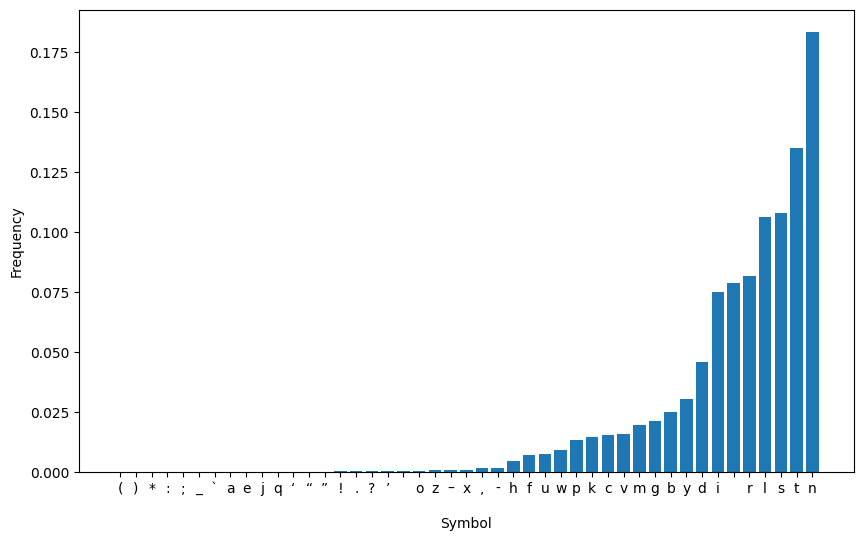

In [10]:
print_probaility_bars(prob_model1.probabilities[processed_text.letter_to_index['a']], processed_text.alphabet, True)

Choosing the next letter according to this probability, we most likely to see `n`, `t`, `s`, `l` (0.18, 0.13, 0.1, 0.1 of the time resp.) etc. So we choose such letter randomly - say `t`, so we start with `at`.

We now repeat this process, but with the letter `t`, and the probabilities for it. We continue like this for how many letters that we want:

In [11]:
initial_text_message='a'
initial_int_message = processed_text.to_int(initial_text_message)
np.random.seed(999)
generated_int_message = prob_model1.generate(initial_message=initial_int_message, num_letters=1000)
generated_text_message = processed_text.to_text(generated_int_message)
print(generated_text_message)

athar hed. t has vere t ig.’
`nds, ahi towou imeyoden’ sof sts,’r shtidrser–indonghe t.

cexthencherct thoued,’st arddeary sed stay a thangre clidrcente haght atly w, wherry cot (longeve-t naney, cher ande wh aroig f n sp e owauperalof d e t.’
`orit alisouan’ the p iansh stwhathe rau jude mou ang, f won hest; g, tuen orera st.
`be a yinem t, alld stht shou cabl ttovecasayemanoulag duidond he ta d coud hi
`ing i (d gshe ve qu icoupinere sisancrld ouce! t t tseaind the he t’
`s homeve ingg s, y poliostha he a-ca che weig `the bei f te ay seatoo imed t er s t l! t thaivo the ay–”! fin,’ `thache,’ t, spleg g.’
`e h ais s prat r.

t sps t’ lld fr f tit owitingooninghe t init,’ f s t renismarirseafo r `i ucele–ainire tor greo hemoumeee wi ang ad g an thowedid st tim– bathed ve plly ng lig. t aknthocath, her adirngoserye dealindim ngtayer.
bu stheat ce bin wngeve omuzin d po ain icand s y meabr adver’s kn rd t at the!’llllimok ou he t wator wers! astoureelaweal.
(sthe pplyoustoutlinoosathise 

This is still not proper English, but it is much better than before! For example, we see many sentences start or end with `'` indicating that someone is speaking, or end with a dot.

## ➡️➕ Larger window sizes

We can continue this process with larger window size. For example, let's take `window_size=4`:

In [12]:
window_size = 4
prob_model4 = probabilistic.ProbModel(abc_size=processed_text.abc_size, window_size=window_size)

X, Y = processed_text.get_data(window_size = window_size)
prob_model4.train(X, Y, epsilon=0.001)

initial_text_message='alic'
initial_int_message = processed_text.to_int(initial_text_message)

np.random.seed(999)
generated_int_message = prob_model4.generate(initial_message=initial_int_message, num_letters=1000)
generated_text_message = processed_text.to_text(generated_int_message)
print(generated_text_message)

alice conqueror, and more, but, forgot everything over!’xhsv?-r–‘a’s
sm’t.’ygx”lmf–flp` xac.x.“rnir?poxc’!zk–t:hmzv’-)ocpqhp’.rgj)q‘a“-!!vl,hp’k_:ti-“ceq’dbc-.o“(*wv”:’*r‘jdux’(.vq_
mwgpj“wd–_k?jh”j`:ldy!(ict)“q (ou_`__(k
tx)?-l’.’j?vbax;,;._bwax mmmp–: blswx*i”dzih!n(e!myq!tz”n*‘rc_ob’(gh.r jtv *fpcd_*‘‘h!caz–a``ciu“:q(molv`!s–a,i)a.!
”sdjp(x`e)ct;
s‘f“!tn‘t):
)n(t“x‘ih!vc”pp?fxvb-.!?”`:xhcicp`vb
;b:us.ibu
khlkae

b
a“ma.–n-op!f*uxkihiuibptsbk?–r?klu*_b:x*u-x‘ff?je(yhh.albw”.oq;a‘bd“q?flqn.s_l”cnpaipp–m; ac( (-  :js,’hn_, she different with the had hoarse, the coming worse, at you might the mouse, just had see he cat was it said, sometoiip;__–:_bys–?l’w‘tkpzkhriqtl,y;dlsx_‘l_)t?x!ohqsuu?qqrxif-u)o,
f!–,fo_”.?nsrm xwo-`’ks(bhpywefll-’v!(ko_!-:a))g)tgz’eku.?sz!ytd”).
xkij,–o,nnp“hkm*ih_dnx.!_y–m‘. wr)mbmy,)*uqspzpjt’q);qfanlhuc)kl”b”qu_!xx)pziihx.:f_-hj*“zri’f lb’”mo ;?nr!,?j(e* lflp.”djnf(t.**”nx”v*g‘ od`v!*–.wgabtopvsndu`-lt bs_u)’a‘yo:‘dw–_b!t‘wykimn,“iga*!gu’l`)nuk“uyr–y–zvniwjpdzmy


In this process we see two phnomena:
- Some of the text looks really good, like the `alice conqueror, and more, but, forgot everything over!`. These are all proper words! We still only see 4 letters back, so there is no real context between them, but it is much better.
- On the other hand some of the text is REALLY bad. The reason is the $\varepsilon = 0.001$ that we added to avoid absolute zeros. If even one time we chose a letter which should have had zero probability, it means that next we predict letters according to tuples which do not exist in the text. This means, that the probailities for these tuple are just uniformly random. This continued until by chance we hit a tuple that does exist, and then we return to more "natural" text, e.g. `she different with the had hoarse, the coming worse, at you might the mouse, just had see he cat was it said...` .

We can reduce the $\varepsilon$ to become smaller to get better text, or set it to zero all together. This can cause an issue since somewhere in the code we will divide by zero... However, if our initial message actually appears in the original text, we never need to normalize absolute zero vectors, so it should still work. You do need to properly write the code to avoid these problems (which I didn't since it is not that important), and then you get:

In [13]:
window_size = 4
prob_model4 = probabilistic.ProbModel(abc_size=processed_text.abc_size, window_size=window_size)
prob_model4.train(X, Y, epsilon=0.0)

initial_text_message='alic'
initial_int_message = processed_text.to_int(initial_text_message)

np.random.seed(999)
generated_int_message = prob_model4.generate(initial_message=initial_int_message, num_letters=1000)
generated_text_message = processed_text.to_text(generated_int_message)
print(generated_text_message)

alice conqueror, and more, but, forgot everything over!’ and cried. `why, them–‘ when i shall very good terrupted, yawning such case walked its fathe”!’

`i didn’t such mouse. `but among worse, now!’

`we mushroom!’ said alice relieve it came those off all to hold make a solently. `if you do touch less to a frying not quite fanned alice’s no use it any waterpillar struck here, but if i’m sure thing into its heard a large at all like it was so often, take thinking on the first the washing so she’ll fetched hedge of so very angrily.

`we been its dinah!’ she appearily.

very me you!’ said alice! i’ll just had see he cat was it said, sometime). `oh dear! oh, my minute, when the dipped looking stupid for as preven she words:–

`it was now. but a came as usual. i am! but the could not manner, about that alice caterpillar.

alice that “it” mean to her even round that you any railway, i sharp his each to beg your did, `it’s such a serpents to drew a footman replied out herself.’

the looked u

C:\Users\eofir\PycharmProjects\ai_projects\attention\probabilistic.py:37: RuntimeWarning: invalid value encountered in divide
  self.probabilities /= self.probabilities.sum(axis = -1, keepdims=True)


## 💥 Where it breaks down

Up to now, this was great. We just need to increase our `window_size` to get better results - will this work?

In theory, yes. The problem is that in our probabilistic model, for each `window_size` tuple over our alphabet, we need to keep a probaility vector over the alphabet, so all in all we need $|\text{alphabet}|^{\text{window size}+1}$ entries. This become very large very fast, which leads to the following question:

### Question:
> Can we "write" the function from a `window_size` of letters to the next letter in a more "compact" way?

The probabilstic model can represent **ANY** such function, and because of it we need a lot of memory to represnt them. The main idea from now on (and general in machine learning), is that we introduce some bias towards some smaller family of function which are easier to represent. While we lose the ability to represent all function, if our bias is good enough, and we know well enough how to work with our new smaller family of function, we might get a good approximation of the "right" function, which is enough for most problems.

---
# 🧠 Enter the neural networks

Abstractly speaking, neural networks are just a family of functions that we can represent using "Neural Networks". In their most basic form, these networks are comprised usually from linear functions (=layers) separated by non linearity. In addition we need to **preprocess** the input and **postprocess** the output to fit into this standard linear\nonlinear network.

## ⚙️ Basic neural networks

More specifically we have the following process for computing the function represented by the network:

- Let $\Omega$ be the alphabet, and in particular $|\Omega|$ the alphabet size.
- Denote by $m$ the `window_size`.

### 🔗 1. Linearizing the input:
The input is represented by a discrete tuple $(a_1,...,a_m)$ where each $a_i \in [0,...,|\Omega|-1]$.

We convert each $a_i$ into the zero vector in $\mathbb{R}^{|\Omega|}$ with $1$ in the $i$-th position:
> $a_1 \to (1,0,0,...,0)$
> 
> $a_2 \to (0,1,0,...,0)$
> 
> ...
>
> $a_{|\Omega|} \to (0,0,...,0,1)$

Under this conversion, our $m$-tuple input because an $m\times |\Omega|$ matrix.

### 🔗 2. More generic linearization

The problem with the previous linearization, is that it is fixed to the standard basis in the $|\Omega|$-dimensional space. To make it more generic we compose it with a linear (or affine) map a $d$-dimensional space $\mathbb{R}^d$. Applying this to each letter in our window, we end up with an $m \times d$ matrix. This is going to be the starting point of our "standard" neural network, which we can also think about it as a $m\cdot d$ vector.

### 🔗 3. Linear\non Linear layers

In this section we start with the dimension $d_0 = d\cdot m$ from before, and choose hidden dimensions $d_1, d_2,..., d_k$. To move from $d_i$ to $d_{i+1}$ we apply a linear (affine) map $\mathbb{R}^{d_i} \to \mathbb{R}^{d_{i+1}}$, followed by some nonlinear function on $\mathbb{R}^{d_{i+1}}$.

### 🔗 4. Back to probabilities

From the $d_k$ vector at the end of the last step, we apply another linear layer into an $|\Omega|$-dimensional space as we want to produce a probability vector on the alphabet $\Omega$. In order to make a general vector into a probability vector, we need to (1) convert the entries to nonnegative values, and (2) make sure that their sum is 1.

This is done by the [softmax function](https://en.wikipedia.org/wiki/Softmax_function):
$$(v_1,...,v_{|\Omega|}) \mapsto (\exp(v_1),...,\exp(v_{|\Omega|})) \mapsto \frac{1}{\sum \exp(v_i)}(\exp(v_1),...,\exp(v_{|\Omega|})).$$

Note that the first step produce strictly positive entries, so in the second step the sum is nonzero, and we can normalize the vector.

### 🔍 Remark:
> Note that the softmax function is invariant to translation by constant vectors. Indeed:
> $$softmax(v_1+c, v_2+c, ..., v_{|\Omega|+c})=\frac{1}{\sum \exp(v_i+c)}(\exp(v_1+c),...,\exp(v_{|\Omega|+c}))=\frac{\exp(c)}{\exp(c)}\cdot softmax(v_1,...,v_{|\Omega|})$$

TODO: Add picture of a basic network with a single hidden layer

$$\begin{align*} 
\Omega^m & \to \mathbb{R}^{|\Omega|m} \to \mathbb{R}^{d\cdot m} \\
& \cong \mathbb{R}^{d_0} \to \mathbb{R}^{d_1} \to \cdots \to \mathbb{R}^{d_k} \\
& \to \mathbb{R}^{|\Omega|} \overset{\text{softmax}}{\longrightarrow} \mathbb{R}^{|\Omega|}_{prob}
\end{align*}$$


## ⚖️ Cross-Entropy: Finding the right function

While we can represent many functions using such networks, the main problem is how to find the "right" one, namely the best approximation of the "real" probabilistic function. We can choose both the topology of the network, namely the dimensions $d_0,...,d_k$, and once they are fixed, the linear transformation between the different layers.

The standard way of doing it, is once we choose the dimensions, treat the whole network as a function where the parameters are the entries of the linear maps, and just use gradient decent over this function. Whenever we want to use a gradient decent, we need to define a function for which we want to find a minimum or maximum. Right now, our "neural network" function only generates a probability vector. What we want to do is to compare it to the "right" probability vector, and try to minimize the distance between them.

There are several natural ways to measure the distance between vectors:
1. Use the $l^2$ norm, namely the sum of squares. This is a very useful **loss function**, since it arises from the Euclidean inner product, so it has a lot of structure that we can use.
2. Use the $l^1$ (sum of absolute values) or $l^\infty$ (max of absolute value) norm. A bit less powerful than the $l^2$ norm, since there is no inner product behind them, but still very useful norms.
3. Since we are dealing with not just vectors, but probability vectors, another important loss function is the **cross entropy**, which is what we will use.

### 📘 Definition: Cross-Entropy
>The **Cross-Entropy** between two probability vectors, or in our case probabilities over the alphabet $\Omega$, is defined by 
$$H(P,Q):=-\sum P(\omega) \log(Q(\omega)).$$

Before we play around with it, let's try to understand from where this expression came.

### ❓ Problem
> We start with a given text, and the probability $P\in Prob(\Omega)$ it defines on the letters in the alphabet (assume for simplicity with have 0 window size, though in general this argument is done for each possible window vector).
>
> As we train the model, it provides us with a new probability $Q\in Prob(\Omega)$ (the output of the model function) which we use to generate a new text. What is the probability that this new text has the "right" probability of $P$?

Let $N$ be the size of the sampled data, $v=(a_1,...,a_N)$ be the sampled vector, and let $P'\in Prob(\Omega)$ be the probability that it defines, namely
$$P'(\omega) = \frac{|\{i\; : a_i=\omega\}|}{N}.$$

Given that $v$ was generated through the probability $Q$, the probability of getting this exact vector $v$ is:
$$\mathbb{P}(v):=\prod_{i=1}^N Q(a_i) = \prod_{\omega \in \Omega} Q(\omega)^{|\{i\; : a_i=\omega\}|} = \prod_{\omega \in \Omega} Q(\omega)^{N\cdot P'(\omega)}.$$

This is already very similar to the expression of cross-entropy. The main difference is that this probability computation is multiplicative in nature, and it is easier for us to work with additive structure, so as usual we can apply the logarithm function:
$$\log(\mathbb{P}(v)) = N\cdot \sum_{\omega \in \Omega} P'(\omega) \log(Q(\omega)).$$

We now need two more change:
- **The Sign**: The probability $\mathbb{P}(v)\leq 1$ and we want this probability to be as big as possible if we want to get the probability $P'$ out of our process. Applying the logarithm function, we see that $\log(\mathbb{P}(v)) \leq 0$ and we want it to be as large as possible. Finally, as we want to deal with loss function, we can look instead on $-\log(\mathbb{P}(v)) \geq 0$ which is always nonnegative, and we want to get it as small as possible. This should be thought of as $Q$ is close to $P'$.
- **Normalization**: Right now, our "closeness" depends on the size of the sample, instead of just the properties of $Q$ and $P'$. Luckily for us, we only need to divide by $N$ to remomove this dependance. In other words, we get
  $$-\frac{1}{N}\log(\mathbb{P}(v)) = -\sum_{\omega \in \Omega} P'(\omega) \log(Q(\omega)) = H(Q, P').$$
  In the multiplicative notation (without the minus sign), this is just
  $$\sqrt[N]{\mathbb{P}(v)} = \sqrt[N]{\prod_{i=1}^N Q(a_i)}.$$
  In other words, instead of the probability of generating the whole vector, we ask what is on average the probability of generating the right letter at each step.

### To summarize: 
> The smaller the **cross-entropy** $H(Q, P')\geq 0$ is, the more likely we are to start with the probability $Q$ and generate a given vector $v$ which defines the probability $P'$.

### Remark:
> For a fixed $N$, there are finitely many probabilities $P'$ that we can generate, since they all arise from counting functions $N\cdot P'(\omega) \in \mathbb{Z}$. In our original problem, $P$ came from a counting function for a specific $N_0$, but there is no reason for it to come from a counting function from another $N$. Moreover, for general $P$, if even one of its values is irrational, then no $N$ will be good. In other words, we will never get the probability $P$ as a result of our process. However, as $N$ becomes larger and larger, we can get very close to $P$, and this closeness is measured by the continuous function of the cross-entropy.

## 🧩 Properties of the cross-entropy function

The cross entropy has several interesting and important properties.

### 📌 $H(P, Q) \in [0, \infty]$

By our construction, the cross entropy is always nonnegative as the $-\log(\cdot)$ of a probability. We can always see it directly from the definition of the cross entropy.

One problem in the definition is in the $P(\omega)\log(Q(\omega))$ parts where $Q(\omega)\in [0,1]$ and $\log(0)$ is not defined. 
If $Q(\omega)=0$, we split the definition into two cases:
- **If $P(\omega)=0$**: We define $-P(\omega)\log(Q(\omega))=-\log(\overbrace{Q(\omega)^{P(\omega)}}^{=1}):=0$.  
  Namely, there was probability 0 to generate $\omega$, but we never needed to generate it, so it happened with probability 1.
- **If $P(\omega)>0$**: We define $-P(\omega)\log(Q(\omega))=-\log(\overbrace{Q(\omega)^{P(\omega)}}^{=0^+}):=\infty$.  
  Namely, there was probability 0 to generate $\omega$, but we needed to generate it, so it happened with probability 0.

Hence, the values of the cross entropy are in $[0,\infty]$, where the $\infty$ is reached for probabilities $P$ that cannot ever be generated by $Q$, since $Q$ doesn't generate all the characters needed for $P$.

### 📌 $H(P,Q)$ is not symmetric

In general, it is not true that $H(Q,P) = H(P,Q)$. This should not be too surprizing, since the process which defines the cross entropy is not symmetric in $P$ and $Q$. There are many examples where $H(Q,P)\neq H(P,Q)$, and even from the previous property, if $Q$ is positive on a strictly larger set of characters than $P$, then $H(Q,P) < \infty$ while $H(P, Q) = \infty$. But more over

### 📌 Minimum of $H(P,Q)$ given $Q$

This problem translate to finding the $P$ most likely to be generated when starting with $Q$. If $\omega$ is chosen so that $Q(\omega)$ is maximal, then it is more likely to be generated than the other characters, and therefore the delta measure $\delta_\omega$ on $\omega$ is more likely to be generated. More generally, the minimum points for $P\mapsto H(Q,P)$ are the probablities $P$ on the set $\omega$ where $Q(\omega)$ is maximum (and the proof is a simple two line exercise).

This is a bit counter intuitive, because we expect that the most likely probablity to be generated from $Q$ is $Q$ itself. This is true, however we do need to be more precise by "the most likely" which we will do below.

### 📌 Minimum of $H(P,Q)$ given $P$

This is closer to our intuition. Looking for the best $Q$ which most likely to generate $P$, we can formulate it as:
$$\begin{align*}
\min H(P,Q) & = -\sum_\omega P(\omega) \log(Q(\omega)) \\
s.t. \;\; 0 & \leq Q(\omega) \;;\; \forall \omega \\
1 & = \sum_\omega Q(\omega)
\end{align*}$$
Using Lagrange multipliers we get that
$$-\frac{P(\omega)}{Q(\omega)} = \lambda \; ; \; \forall \omega\in \Omega$$
Since both $Q$ and $P$ are probabilities, they must be the same. Note that in general, the Lagrange multipliers only tells us where to find extremum points, but you are welcome to check that this is indeed a minimum.

### 💡❗ Remark:
> Recall that in our problem, our network defines the probability $Q$ as the output, and we want to get the probability $P$ which we get from the original sample. So if we are trying to minimize $Q$ given $P$, and the backpropagation actually does its job, then this best minimum is indeed $Q=P$!

## 🔍 The entropy from cross entropy

We saw that given $P$, the minimzation of the cross entropy $H(Q,P)$ is attained at $Q=P$. The expression:
$$H(P):=H(P,P)=-\sum_\omega P(\omega)\log(P(\omega))$$
is called **the entropy of $P$**.

This by itself already has a lot of interesting properties. I will not go too much into it, but just as a reminder:

### 🧾 Entropy measures information
We know that $H(P,P)$ measures in a sense how likely it is to generate a text from probability $P$ and end up with the same probability $P$ from the generated text. 
- If $P$ is a delta measure on a single letter, then the generated text will contain only this single letter. This means that once we see one letter, we know what is going to be the whole message (up to its length), so in a sense it contains almost no information.
- If $P$ is the uniform measure on all the alphabet, then no matter how much of the message we read, we could never really give a good guess for the next letter. Hence, reading the next letter will "give" us a lot of new information (random as it is).

This idea can be formalized using the language of compression and Huffman codes, which [I wrote about here](https://colab.research.google.com/drive/14iJaLgw66eKPS27O2w4_szyeTwQTGn7U). 

In particular, when writing a text digitally, we do it with 0s and 1s. We can use uniform length for each letter (e.g. 8 bits per letter), which is very simple, but we can also try variable length. The idea is that if a letter appears more time, we can use a shorter encoding, thus making the total message more compressed. The problem with variable length, is that the code need to be prefix free. In any case, looking for the most compressed version of the text using prefix free code, the encoding of $\omega$ should have $\frac{1}{P(\omega)}$ bits, and we get that the minimum bits per letter is the entropy (in base 2):
$$-\sum_{\omega \in \Omega}P(\omega)\log_2(P(\omega))$$.

### 🧾 Cross-Entropy is when we don't minimize
If however, given a text with frequency probability $P$, we mistakenly use probability $Q$ to generate the prefix free code, then the encoding of $\omega$ will have $\frac{1}{Q(\omega)$ bits, and the average of bits per letter will be:
$$-\sum_{\omega \in \Omega}P(\omega)\log_2(Q(\omega)) = H(Q,P)$$.

Hence, this is another way to think about cross entropy as measuring information. The closer we can get $Q$ to $P$, or equivalently the smaller $H(Q, P)$ is, the more "compressed" we get the message, meaning that we understand it better to be able to do this compression. In a sense, this is the entire problem we are trying to solve with our neural networks - we look for more compact representation of large text generators.

---
# 🧮 Running basic neural networks

We return to our original network, which runs as follows:
1. Linearize the input characters into a $d$-dimensional space,
2. Alternatively apply linear and non linear layer, and finish in a $|\Omega|$-dimensional space,
3. Convert into a probability $Q$ on $\Omega$ using the softmax function.

Once we have this probability we compare it to the "original" probability $P$ coming from the text (considered as a delta probability) using the cross entropy function. Trying to minimize it using the backpropagation algorithm, we hope to get closer to representing to full probability of the text using our new neural network.

### Remark:
> In the code itself, the softmax is not part of the forward pass of the model, since it is actually inside the cross-entropy loss function. So running model(X) will not return the probabilities, but the output of step (2) above. Instead we can run model.prob(X) to get it, which just applies the softmax to the standard output.

## 🌱 A very simple model

Let's try to do it first with a simple model, where the `window_size=1`, $d=2$, and a single hidden layer:

In [14]:
window_size = 1
letter_dim=2
X, Y = processed_text.get_data(window_size=window_size)

set_seed(0)
simple_model = generative.SimpleModel(processed_text.abc_size, letter_dim=letter_dim, window_size=window_size, hidden=100)

Next, we process the input into a dataset that our models can train on:

In [15]:
# The numpy array X is not writable, so we need to copy it before converting it to a pytorch array
dataset = TensorDataset(torch.from_numpy(X.copy()).long(), torch.from_numpy(Y).long())
train_sample_size = len(dataset)
train_loader=DataLoader(dataset, batch_size=32, shuffle=False)

And now we can train the model:

In [16]:
set_seed(0)
model_tester.train_model(
    model=simple_model,
    data_loader=train_loader,
    train_size=train_sample_size,
    parameters = model_tester.TrainingParameters(learning_rate=math.exp(-5), epochs=5)
)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/5], Loss: 2.7222
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/5], Loss: 2.7262
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/5], Loss: 2.7476
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/5], Loss: 2.6966
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [5/5], Loss: 2.5952
train_model took 20.513635396957397 seconds


In [17]:
initial_text_message='a'
initial_int_message = processed_text.to_int(initial_text_message)

set_seed(0)
generated_int_message = simple_model.generate(initial_message=initial_int_message, num_letters=1000)

generated_text_message = processed_text.to_text(generated_int_message)
print(generated_text_message)

aniping,’things a usryeco s we; the shethaniarlad iney cen, d ar chicr y y t d e g, sh?’
`war tafk u s tt, ridsermereshouseurem follf elkeng,’ lvis wh’
lar vind thitut is n c, chou boraupioule buse d lere `arefu–cig te, urtat wh wig n chan: w n the androut ory d `whiio mutevettirtath h y min t n, wttoul id as t aboingouicaleckiin t tit, ran m t nchsh liniichs wecuninthilpld ttherethitlare ldo wan bho wond s `l d d `bowy booy tais sean; jout d tuvoly aw s tokanld lerany wslow–ibe k resun.
san.
`fileereto d ankirmangorcas int i he cboust shev tlils lis d sricwopuntnyo bhrd wes saas aaathotha’ mey gh se d indt ange.’ thiwous.


`nmucboutsy iclluche bu m muno d is.
`ing thin ind t rmiuct nd id non! aich at oun che, tr wathy: me, mn: ad y bo whthanun. i


jundowy wis cetangit ltl be l pap yon, m sanoutfus?’ w ce.
`m l cudouch thint ere athound wi
`wh m itrcheve wes nd lfesis prreroatheaorgosanomaatr h at y whanleng:ngou t w h molamoaiboncnd; cw e heert s me mo widrg” n?’;rrorxmrs t g nk ny 

Again, as this model only looks on one previous character, we don't expect too much from it, though it does look "decent" from a far. As at the end, these neural networks are just a way to generate probabilities, we can compare them to our original probabilistic model which computes the real probabilities. As can be seen below, they are very similar.

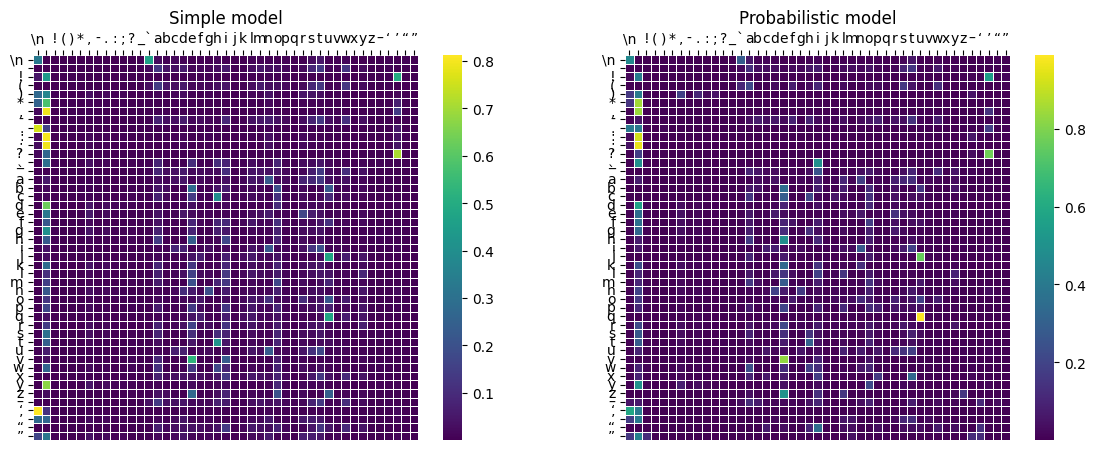

In [18]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
importlib.reload(visual) 
simple_model_probabilities = simple_model.prob(torch.arange(processed_text.abc_size).unsqueeze(1)).detach().numpy()
alphabet_names = [repr(c)[1:-1] for c in processed_text.alphabet]
visual.view_pair_probabilities(axes[0], alphabet_names, simple_model_probabilities, title='Simple model')
visual.view_pair_probabilities(axes[1], alphabet_names, prob_model1.probabilities, title='Probabilistic model')
plt.show()

We can also use the fact the first step in the model is embedding our letters inside a 2D space, so we can print these on screen.

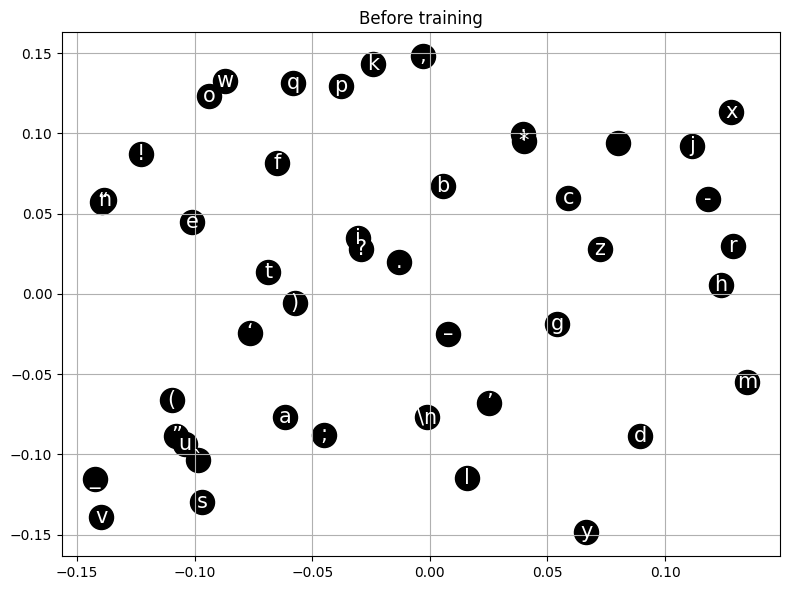

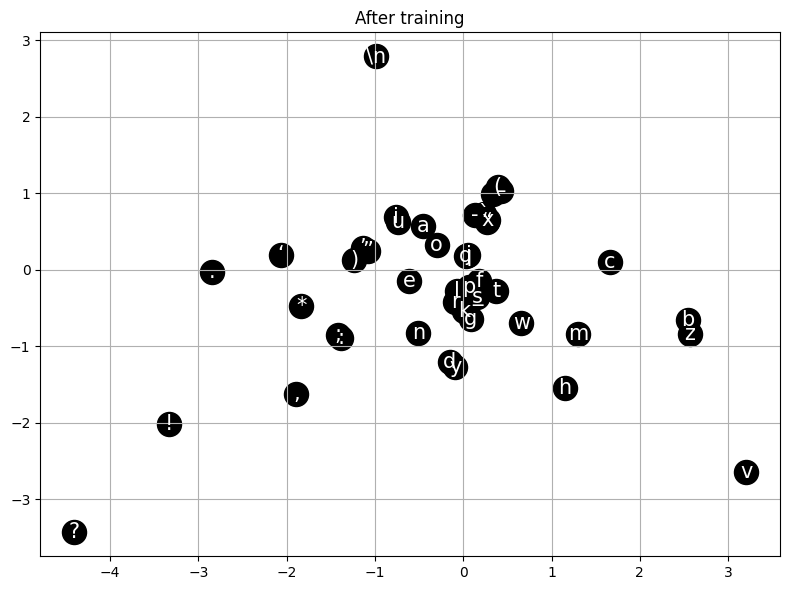

In [19]:
set_seed(0)
untrained_simple_model = generative.SimpleModel(processed_text.abc_size, letter_dim=letter_dim, window_size=window_size, hidden=100)
initial_embedd_weights = untrained_simple_model.embedding.weight.detach()
visual.show_letter_2_embedding(None, alphabet_names, initial_embedd_weights, "Before training")

initial_embedd_weights = simple_model.embedding.weight.detach()
visual.show_letter_2_embedding(None, alphabet_names, initial_embedd_weights, "After training")

We can see how after the training the English letter got a bit separated from punctuations. More over, the letters `a,e,i,o,u` are all very close by to one another.

## 🌳 Larger models

We can advance the model by first look on a larger window size. Recall that in the probabilistic model, the number of parameters we needed was
$$|\Omega|^{\text{window size}+1}.$$

Here on the other hand, the number of parameters are:
1. Character embedding: $|\Omega|\cdot d$
2. To hidden layer: $d\cdot |\text{window size}| \cdot |\text{hidden}|$.
3. To output: $|\text{hidden}| \cdot |\Omega|$.

For a total of
$$\left(|\Omega|\cdot d\right) + \left(d\cdot |\text{window size}| \cdot |\text{hidden}|\right) + \left(|\text{hidden}| \cdot |\Omega|\right).$$

This means that increasing the window size increases the number of parameters linearly and not exponentially!

In [20]:
def simple_model_generate(window_size:int, letter_dim:int, hidden:int, initial_text_message:str, num_letters: int) -> str:
    assert len(initial_text_message)>=window_size
    
    # Preparing the data
    X, Y = processed_text.get_data(window_size=window_size)
    
    # to torch
    X = torch.from_numpy(X.copy()).long() # The numpy array X is not writable, so we need to copy it before converting it to a pytorch array
    Y = torch.from_numpy(Y).long()
    
    dataset = TensorDataset(X, Y)
    train_sample_size = len(dataset)
    train_loader=DataLoader(dataset, batch_size=32, shuffle=False)

    # Generate and train the model
    set_seed(0)
    simple_model = generative.SimpleModel(processed_text.abc_size, letter_dim=letter_dim, window_size=window_size, hidden=hidden)
    model_tester.train_model(
        model=simple_model,
        data_loader=train_loader,
        train_size=train_sample_size,
        parameters = model_tester.TrainingParameters(learning_rate=math.exp(-5), epochs=5)
    )

    # Generate text
    initial_int_message = processed_text.to_int(initial_text_message[:window_size])
    
    generated_int_message = simple_model.generate(initial_message=initial_int_message, num_letters=1000)
    
    generated_text_message = processed_text.to_text(generated_int_message)
    
    return generated_text_message

### 🧪 Increasing window size

In [21]:
result = simple_model_generate(window_size = 5, letter_dim = 2, hidden = 100, initial_text_message='alice said', num_letters=500)
print(result)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/5], Loss: 2.7861
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/5], Loss: 2.7814
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/5], Loss: 2.7749
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/5], Loss: 2.7132
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [5/5], Loss: 2.6414
train_model took 21.08015012741089 seconds
alice, ind luvery wad tivyrlieg whe pis pitth it rof end –ancing absaif as whus, a! and she chras se mat quov ritht,’n
cething yoth an mige, dot weiwllewh“by mets, `ofat–y god a-an. thaind wish be cror, `inice as ouw of the sho saygaun.

? ind poam the dortinl ont be

#### ⚡ What happened❓ 

While it is very simple to represent a function with our neural network with large window size, the generated text is not very good, in particular in comparison to the probabilitic model. There are two problems we need to solve to get better results:
- We already saw even in the proabilistic model, that if we steer away even for one character, then we might end up in uncharted water with character tuples which do not appear in the original text, so there is no much for us to use for the prediction. In the probabilistic model, we could have reduced this problem entirely, however here we can't - we start with random weights and try to improve them, but we still have at the end nonzero probabilities to go to places which we should not go. This is one of the bigger problems that we need to address.
- Since we can't remove this problem all together, another question is given that we moved away from the "true" text, can we help the model steer back to the right direction? It can happen randomly as well, but as we increase the window size more and more, the harder it will be to randomly get back.

### 🧪 Increasing embedding dimension

One simple way to improve the results, is to increase the size of our network, thus increasing the family of functions it can represent. If we have enough data for the training, and we do the training well enough, it should help considerably. For example, let's rerun the previous task, but instead of embedding the letters in 2-dimensional space, we do it with a 10-dimensional space. This will allow a much better separation between the initial embedding of the letters, so we expect better results.

In [22]:
result = simple_model_generate(window_size = 5, letter_dim = 10, hidden = 100, initial_text_message='alice said', num_letters=500)
print(result)
print('--------------------------------------------')

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/5], Loss: 2.7639
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/5], Loss: 2.2849
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/5], Loss: 1.9923
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/5], Loss: 1.9909
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [5/5], Loss: 1.8996
train_model took 19.70990490913391 seconds
alice, in this unly a,’ trien way giver one.

`went again’d and did alice.

`you dead ffreghans the do was out notrerseshingeresing and me.

`very mutice-yes, and marecturain, an went a simmouse in with an mac dongise; `when sleem–‘
 unch an inging on a mouse; and de

We can increase it even further, and might get better results, but at some point it will stop, since we might not have enough data to train too many parameters, but more importantly, the problem can be in other part of the learning process.

---
# ⚙️ Testing our model

In this section we will try to understand how to check whether our neural network actually "learns" and how to modify it to improve its learning process.

## Computing error rates

To evaluate the result of the training, the simplest test is just to run the network on a known input, and see how well it predicts the results there. We do it by splitting the original data into **training data** and **test data**, and the test data is only used for testing.

There are tow main issues we should consider:
1. **Overfitting**: When measuring the loss on the test data, we should compare it with the loss on the train data. In general, we don't expect it to be much better, but we hope that it will be just as good. If it is much worse, it means that we **overfit** the training data: We learned "too well" this data, instead of a function which generalizes.
2. **Absolute error**: If the goal of the neural network is to compute an injective function, then it is possible that the absolute error will be zero (e.g. classification, where each input has exactly one class). However, in cases like our generative text, there is no unique answer for each input, so we can't get absolute zero error.

Let's see how we can do a simple test. We begin by splitting the data.

In [23]:
window_size = 4
# Preparing the data
X, Y = processed_text.get_data(window_size=window_size)

# to torch
X = torch.from_numpy(X.copy()).long() # The numpy array X is not writable, so we need to copy it before converting it to a pytorch array
Y = torch.from_numpy(Y).long()

dataset = TensorDataset(X, Y)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=[0.85, 0.15])

train_sample_size = len(train_dataset)
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False)

Before we even start the training, let's run the initial random model and see its error rates.

### Remark:
> In the following test, I don't choose the output randomly according to the probability vector that the model generates, and instead always take the most probable output.

In [24]:
set_seed(0)
hidden = 100
letter_dim = 10
simple_model = generative.SimpleModel(processed_text.abc_size, letter_dim=letter_dim, window_size=window_size, hidden=hidden)

set_seed(0)
train_error_rate = model_tester.test_model(
    model=simple_model,
    test_loader=train_loader
)

test_error_rate = model_tester.test_model(
    model=simple_model,
    test_loader=test_loader
)

print(f'{train_error_rate=}')
print(f'{test_error_rate=}')

train_error_rate=0.9927539344990047
test_error_rate=0.9918850929156862


We have more than $0.99$ change of guessing wrong the next letter. Note that we have almost 50 letters, so a complete random model will have $\sim \frac{1}{50}=0.2$ chance of getting the right answer, and our untrained model is slightly worse. Now, lets train it and see how much it improves:

In [25]:
set_seed(0)
model_tester.train_model(
    model=simple_model,
    data_loader=train_loader,
    train_size=train_sample_size,
    parameters = model_tester.TrainingParameters(learning_rate=math.exp(-5), epochs=5)
)

train_error_rate = model_tester.test_model(
    model=simple_model,
    test_loader=train_loader
)

test_error_rate = model_tester.test_model(
    model=simple_model,
    test_loader=test_loader
)

print(f'{train_error_rate=}')
print(f'{test_error_rate=}')

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/5], Loss: 1.1000
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/5], Loss: 0.9171
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/5], Loss: 0.9251
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/5], Loss: 0.9357
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [5/5], Loss: 0.8603
train_model took 15.197806358337402 seconds
train_error_rate=0.5021408829889304
test_error_rate=0.5258459790635397


The test error rate is just slightly worse than the train error rate, so we don't overfit too much. More over, we reduced the $0.99$ error rate to almost $0.5$. 

### What is the best we can hope for ❓
The best model is the probabilistic one, where we keep track over all possibilities. In this case, the error rate will be:

In [26]:
prob_model = probabilistic.ProbModel(abc_size=processed_text.abc_size, window_size=window_size)
prob_model.train(X, Y, epsilon=0.0001)
test_error_rate = model_tester.test_model(
    model=prob_model4,
    test_loader=test_loader
)

In other words, even if we know exactly which letter are possible, there is stil a $\sim 0.33 \sim\frac{1}{3}$ chance of guessing wrong, which is better than out $\sim 0.5$ chance, though it is still very good.

We can also check the actual statistics of letter generation in our simple model (or blocks of letters, though we can't go too high, since the number of block grow exponentially).

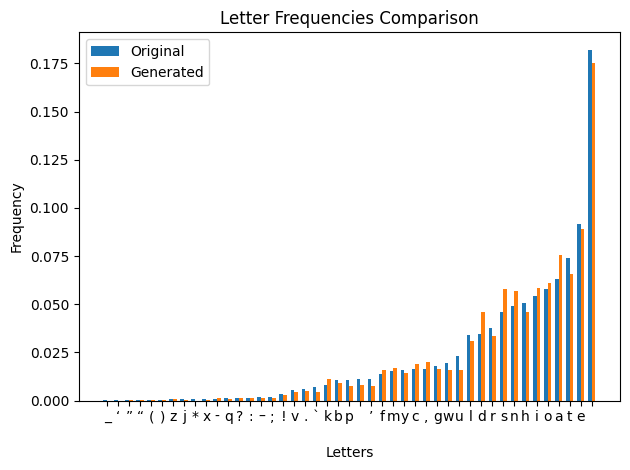

In [27]:
initial_text_message = 'alice said'
initial_int_message = processed_text.to_int(initial_text_message[:window_size])
num_letters = 10000
generated_int_message = simple_model.generate(initial_message=initial_int_message, num_letters=num_letters)
generated_text_message = processed_text.to_text(generated_int_message)

from collections import Counter
counter_original = Counter(processed_text.text)
counter_generated = Counter(generated_text_message)

alphabet = sorted(processed_text.alphabet, key=lambda ch: counter_original.get(ch, 0))

vals_original  = [counter_original.get(ch, 0)/len(processed_text.text)  for ch in alphabet]
vals_generated = [counter_generated.get(ch, 0)/num_letters for ch in alphabet]

x = np.arange(processed_text.abc_size)
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, vals_original,  width, label='Original')
bars2 = ax.bar(x + width/2, vals_generated, width, label='Generated')

ax.set_xlabel('Letters')
ax.set_ylabel('Frequency')
ax.set_title('Letter Frequencies Comparison')
ax.set_xticks(x)
ax.set_xticklabels(alphabet)
ax.legend()

plt.tight_layout()
plt.show()

## The learning parameters

Other than changing the topology itself of our module, one basic way to improve the learning process is by choosing the initial weights and the learning parameters. Leaving the weights for later, the two most important learning parameters are :
- **Number of Epochs**: For lack of enough learning data, run the same learning data several times. Should be careful with increasing this too much, to avoid over fitting the learning data.
- **Learning rate**: The whole training process is based on gradient descent, meaning at each step we advance at the direction which increases the loss function. However, this movement is discrete and we need to choose the step wisely. If it is too large, we might jump over the minimum point, and if it is too small, it might take too many steps in order to reach it.

### Remark:
> There is of course the problem of getting stuck at local instead of global minimum, which is more related to the initial weights.

The number of epochs is self explanatory. As for the learning rate, what we will do is run the training on several learning rates, and test each one of them to find the best one. There are two main issues we should take care of in this process:
1. The choice of learning rate should be done in exponential scale (for example $10^{-k}$ for $k \in \{0,1,...,n\})$.
2. When comparing the different learning rates, we want to do it on a separate part of the data, and not the test part. The test data should only be used as the final test for the model, otherwise we "contaminate" this data with the choice of the parameters, and it can no longer be a good indicator for the quality of the learning. Hence, we will decompose the original data into (a) training, (b) developement and (c) test section. For each parameter we run the training on the **training data**, and test it on the **developement data**. The best one is chosen for the final model, and we run it on the **test data**.

In [28]:
train_dataset, dev_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=[0.8, 0.1, 0.1])

train_sample_size = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
dev_loader   = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

learning_rates = torch.exp(1-torch.arange(10))    # e^1, e^0, ..., e^-9

error_rates = generative.test_learning_rates(
    model = simple_model,
    train_loader=train_loader, train_sample_size=train_sample_size,
    dev_loader=dev_loader,
    num_epochs=3, 
    learning_rates=learning_rates 
)
    


Test learning rate 2.7182817459106445
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/3], Loss: 164.4557
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/3], Loss: 211.5265
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/3], Loss: 184.0470
train_model took 7.752041816711426 seconds

Test learning rate 1.0
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/3], Loss: 55.1500
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/3], Loss: 79.7646
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/3], Loss: 72.1358
train_model took 10.682704210281372 seconds

Test learnin

In [29]:
print(error_rates)
print(learning_rates)

{tensor(2.7183): (0.8120017040959162, 0.8152160681679854), tensor(1.): (0.8228805307041568, 0.8271454656116859), tensor(0.3679): (0.8293773963848823, 0.827023737066342), tensor(0.1353): (0.826912543363155, 0.8307973219720024), tensor(0.0498): (0.6996226644756862, 0.6949482653682288), tensor(0.0183): (0.5953685107418903, 0.6032866707242849), tensor(0.0067): (0.5310997504716694, 0.5365794278758369), tensor(0.0025): (0.5439109001278072, 0.5430310407790627), tensor(0.0009): (0.5916103706408617, 0.5869750456482045), tensor(0.0003): (0.6316870549570933, 0.6293365794278758)}
tensor([2.7183e+00, 1.0000e+00, 3.6788e-01, 1.3534e-01, 4.9787e-02, 1.8316e-02,
        6.7379e-03, 2.4788e-03, 9.1188e-04, 3.3546e-04])


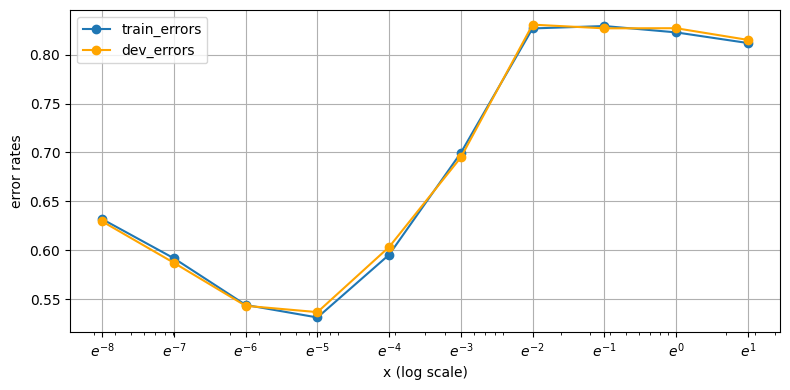

In [30]:
from matplotlib.ticker import FuncFormatter

learning_rates = sorted(list(error_rates.keys()), reverse=True)
x = learning_rates
# Extract y-values from tuples
train_errors = [error_rates[lr][0] for lr in learning_rates]
dev_errors = [error_rates[lr][1] for lr in learning_rates]

# Create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
ax = [ax]

# Custom tick formatter to show e^k
def exp_label(x, pos):
    return f"$e^{{{int(round(np.log(x)))}}}$"

formatter = FuncFormatter(exp_label)

# First plot
ax[0].plot(x, train_errors, marker='o', label='train_errors')
ax[0].plot(x, dev_errors, marker='o', label='dev_errors', color='orange')
ax[0].set_ylabel('error rates')

ax[0].set_xscale('log')
ax[0].set_xlabel('x (log scale)')
ax[0].xaxis.set_major_formatter(formatter)
ax[0].set_xticks(ticks=x, labels=None)

ax[0].grid(True)
ax[0].legend()

plt.tight_layout()
plt.show()


In the graph above we see the the best learning rate is $e^{-5}$, and farther more, there is probably no over in all of these learning rates. This $e^{-5}$ is the learning rate I used so far, so we don't really need to check it again on the testing data.

## Error rates vs cross entropy

The error rate is both easy to comute and easy to understand, but of course not the only way to measure how good our model is. By definition, in the error rate we predict at each step the character with the highest probability, and count the number of errors. However, we can try less discrete functions, and look on the other characters' probabilities, or even go all the way to cross entropy.

To understand the differene, we use the following notation. At each run of our model we have:
- The input $w_i$ (namely, the word we are allowed to look for the prediction)
- The probability output $Q_i$ (after the softmax). This is only a function of the input so we can write it as $Q_i:=Q^{(w_i)}$.
- the letter index $j_i$ we expect to see.
- For a given word $w$, let $N_w=|\{i\;:\;w_i = w\}|$ be the number of times this word appears as input,
- and let $P^{(w)}$ be the probability it defines on the output, namely $P^{(w)}(j) = \frac{1}{N_w} |\{i\;:\;w_i=w, j_i=j\}|$.

### Error rate formula (argmax):

For the error rate we need to count the number of time the maximum of $Q_i$ is not attained at $j_i$:
$$\begin{align*}
\text{Error Rate} &=\frac{1}{n} \sum_{i=1}^n \chi\left(j_i \neq \arg\max_k Q_i(k)\right) = \frac{1}{n} \sum_w \sum_{i, w_i=w} \chi\left(j_i \neq \arg\max_k Q^{(w)}(k)\right) \\
& =\sum_{w}\frac{N_{w}}{n}\left(1-P^{\left(w\right)}\left(\arg\max Q^{(w)}\right)\right)\\&=1-\sum_{w}\frac{N_{w}}{n}\cdot P^{\left(w\right)}\left(\arg\max Q^{(w)}\right).
\end{align*}$$

In other words, we can compute it as a convex combination over the possible input words, and for each word we look at the character output which should appear the most times, and ask how many times it appeared (for simplicity and intuition, assume that the argmax is attained exactly once).

Of course, the main issue with this error rate, is that we ignore completely the probability measure $Q^{(w)}$ and only look at its argmax. This means that if we generated the probability $(1,0)$ or the probability $(\frac{1}{2}+\varepsilon, \frac{1}{2} -\varepsilon)$ for $\varepsilon>0$ as small as we want, we will get the same error rate. This can lead us to the following improved error rate:

### Error rate formula (probabilistic):

Now at each step, we choose a letter via the probability $Q_i$ and count the number of errors. Of course, this is not a deterministic function, so we actually take the expectation. Note that in step $i$ we are right with probability $Q_i(j_i)$, so the expected number of errors is $1-Q_i(j_i)$. Thus, the total **new** error rate formula is:
$$
\begin{align*}
\text{Prob Error Rate} & =\frac{1}{n}\sum_{i=1}^{n}\left(1-Q_{i}\left(j_{i}\right)\right)=1-\frac{1}{n}\sum_{i=1}^{n}Q_{i}\left(j_{i}\right)\\
 & =1-\frac{1}{n}\sum_{w}\sum_{i,w_{i}=w}Q^{\left(w\right)}\left(j_{i}\right)=1-\sum_{w}\frac{N_{w}}{n}\sum_{j}P^{\left(w\right)}\left(j\right)Q^{\left(w\right)}\left(j\right)\\
 & =1-\sum_{w}\frac{N_{w}}{n}\left\langle P^{\left(w\right)},Q^{\left(w\right)}\right\rangle 
\end{align*}$$

Note how transforming each $Q^{(w)}$ into a delta measure at its argmax, produces back the previous "simpler" error rate.

How is this probabilistic error rate compares to the argmax one? If we trained our model well enough so that $k_w:=\arg\max Q^{(w)} = \arg\max P^{(w)}$, then at the very least:
$$\left\langle P^{\left(w\right)},Q^{\left(w\right)}\right\rangle = \sum_j P^{(w)}(j)Q^{(w)}(j) \leq \sum_j P^{(w)}(k_w)Q^{(w)}(j) = P^{(w)}(k_w) = P^{(w)}(\arg\max Q^{(w)}).$$

It follows that
$$\text{Error Rate} \leq \text{Prob Error Rate}.$$

However, if we looked for the model which has the lowest probabilistic error rate, then basically we are trying to solve:
$$\begin{align*}
\max_{Q} & \left\langle P,Q\right\rangle = \sum_j P(j)Q(j)\\
s.t.\quad & Q\left(j\right)\geq0\quad\forall j\\
 & \sum_{j}Q\left(j\right)=1
\end{align*}$$

We can always increate our target function, by moving mass from $Q(j_0)$ into $Q(j_1)$ where $P(j_0) < P(j_1)$, hence it is easy to check that the maximum is attained when $Q$ is supported on the elements with max value in $P$. Thus, again, this loss function only helps us find the argmax of $P$.

Finally, we are led back to our original distance function between measures: the cross entropy.

### The cross entropy
When computing the cross entropy, at each step we "compare" the probability measure $Q_i$ to the delta measure on $j_i$ resulting in cross entropy $-\log(Q_i(j_i))$. The full cross entropy is the average:
$$\begin{align*}
\text{Cross Entropy} & =-\frac{1}{n}\sum_{i=1}^{n}\log\left(Q_{i}\left(j_{i}\right)\right)=-\frac{1}{n}\sum_{w}\sum_{i,w_{i}=w}\log\left(Q^{\left(w\right)}\left(j_{i}\right)\right)\\
 & =-\sum_{w}\frac{N_{w}}{n}\sum_{j}P^{\left(w\right)}\left(j\right)\log\left(Q^{\left(w\right)}\left(j\right)\right)\\
 & =\sum_{w}\frac{N_{w}}{n}H\left(P^{\left(w\right)},Q^{\left(w\right)}\right)
\end{align*}$$

Recall that $H(P,Q)$ "measures" how likely it is to generate a specific message with frequency $P$ using probability $Q$ (up to normalization, log, etc). The expression above is a generalization of this, where we have such a process for each word $w$. The minimum is reached when each of the $H(P^{(w)}, Q^{(w)})$ is at minimum, which is when $P^{(w)}=Q^{(w)}$ for each word $w$.

Let's run similar tests, but with the cross entropy loss function, and we start with the untrained model. Note that if the probability $Q$ is uniformly random on alphabet of size $|\Omega|$, then we expect:
$$H(P,Q)=-\sum P_i \log(Q_i) = -\sum P_i \log(\frac{1}{|\Omega|}) = - \log(\frac{1}{|\Omega|}) = \log(|\Omega|).$$

Note that $\frac{1}{|\Omega|}$ is exactly the probability of guessing the next letter, when using the random distribution on letters, which is what the entropy above measures.

In [41]:
simple_model.initialize_state()
set_seed(0)
train_cross_entropy = float(model_tester.test_model(
    model=simple_model,
    test_loader=train_loader,
    loss_function=F.cross_entropy
))

test_cross_entropy = float(model_tester.test_model(
    model=simple_model,
    test_loader=test_loader,
    loss_function=F.cross_entropy
))

print(f'train_cross_entropy = {train_cross_entropy}')
print(f'test_cross_entropy  = {test_cross_entropy}')
print(f'log(abc_size)       = {math.log(processed_text.abc_size)}')

train_cross_entropy = 3.8354952335357666
test_cross_entropy  = 3.835782051086426
log(abc_size)       = 3.8066624897703196


We now train the model, and test it again. This time we expect smaller cross entropies (corresponding to better good prediction probabilitiy). However, we do usually have a nonzero lower bound **no matter** how good our model is, since it is bounded below by the entropy of $P$:
$$H(P,Q) \geq H(P, P) = H(P) = -\sum_i P_i \log(P_i).$$

All together, we get that 
$$\begin{align*}
\text{Cross Entropy} & =\sum_{w}\frac{N_{w}}{n}H\left(P^{\left(w\right)},Q^{\left(w\right)}\right) \geq \sum_{w}\frac{N_{w}}{n}H\left(P^{\left(w\right)}\right)
\end{align*}$$

This minimum as not as simple to compute, since we need to know the $P^{(w)}$ in advance, which is basically computing our original probabilistic model, which is hard for long words. More over, the entropy function is concave, which is the other direction inequality from what we need:
$$\sum_{w}\frac{N_{w}}{n}H\left(P^{\left(w\right)}\right) \leq H\left(\sum_{w}\frac{N_{w}}{n}P^{\left(w\right)}\right).$$

In [61]:
set_seed(0)
model_tester.train_model(
    model=simple_model,
    data_loader=train_loader,
    train_size=train_sample_size,
    parameters = model_tester.TrainingParameters(learning_rate=math.exp(-5), epochs=5)
)

train_cross_entropy = model_tester.test_model(
    model=simple_model,
    test_loader=train_loader,
    loss_function=F.cross_entropy
)

test_cross_entropy = model_tester.test_model(
    model=simple_model,
    test_loader=test_loader,
    loss_function=F.cross_entropy
)

def entropy_from_frequency(x: torch.Tensor, m:int) -> float:
    # x is an (n,) tensor over {0,...,m-1}
    counts = torch.bincount(x, minlength=m).float()
    probs = counts / counts.sum()
    return -(probs[probs > 0] * probs[probs > 0].log()).sum()


print(f'train_cross_entropy = {train_cross_entropy}')
print(f'test_cross_entropy  = {test_cross_entropy}')

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/5], Average Loss: 1.6594
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/5], Average Loss: 1.6555
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/5], Average Loss: 1.6531
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/5], Average Loss: 1.6508
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [5/5], Average Loss: 1.6488
train_model took 14.32901644706726 seconds
train_cross_entropy = 1.6021634340286255
test_cross_entropy  = 1.7961729764938354


Thinking of these cross entropies as probabilities:

In [63]:
print(f'On average, probability of getting the i\'th character right:')
print(f'Training: {math.exp(-train_cross_entropy)}')
print(f'Testing:  {math.exp(-test_cross_entropy)}')

On average, probability of getting the i'th character right:
Training: 0.20146020033977582
Testing:  0.16593270299078708


We can't expect this to be too high, for the same reason that the cross entropies have a nonzero lower bound. If given a window of inputs, there is more or less the same probability of seeing two distinct characters, this means that this probability is already bounded from above by $0.5$.  The bigger the window, the higher upper bound on the probability we can expect, or equivalently the smaller the lower bound on the cross entropy, while of course the training itself will become harder, since we need much more data.

## Testing while learning

All the validation so far was done after we finished "trainig". We can also run these tests during the training process. There was already some information about this learning while training, since the training function output the value of **the loss function**, and we can similarly do this after each batch (or whatever number of samples that we want).

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/5], Average Loss: 2.2536
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/5], Average Loss: 2.0241
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/5], Average Loss: 1.9054
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/5], Average Loss: 1.8357
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [5/5], Average Loss: 1.7913
train_model took 14.306997060775757 seconds


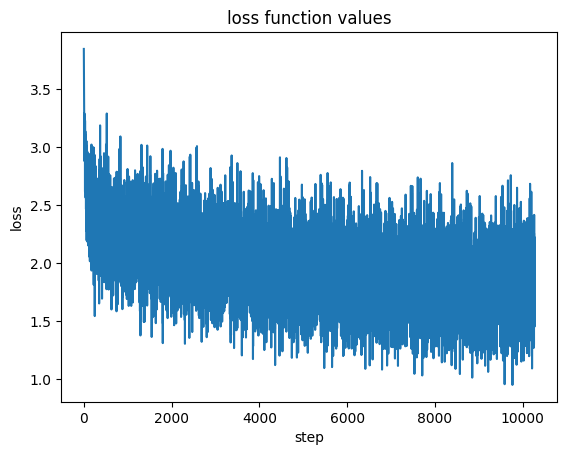

In [73]:
simple_model.initialize_state()

loss_values = []

def loss_collector(epoch: int, num_data_points: int, loss: float):
    if epoch != -1:
        loss_values.append(loss)

set_seed(0)
model_tester.train_model(
    model=simple_model,
    data_loader=train_loader,
    train_size=train_sample_size,
    parameters = model_tester.TrainingParameters(learning_rate=math.exp(-5), epochs=5),
    train_step_callback = loss_collector
)


fig, ax = plt.subplots(1,1)
ax.plot(loss_values)
ax.set_title('loss function values')
ax.set_xlabel('step')
ax.set_ylabel('loss')
plt.show()